In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import imutils

# loading images from the dataset folders

In [ ]:
import os
import cv2
data = []
labels = []
img_name=[]
class_label = 0

def load_images_from_folder(folder,class_label):    
    for filename in os.listdir(folder):    
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            
            img = cv2.resize(img,(224,224))
            img = img.reshape(224,224,3)
                        
            data.append(img)           
            labels.append(class_label)
    class_label=class_label+1
    return class_label

class_label = load_images_from_folder('C:/Users/Ajay/OneDrive/Projects/COVID/COVID-DATASET/Non-COVID',class_label)
class_label = load_images_from_folder('C:/Users/Ajay/OneDrive/Projects/COVID/COVID-DATASET/COVID',class_label)

# Creating mask of the lung

**Step 1:** otsu thresholding  
**Step 2:** find local peaks  
**Step 3:** watershed segmentation  
**Step 4:** removal of irrelevant segments  
**Step 5:** Morphological gradient and binary closing  
**Step 6:** Plotting all contours and extracting largest contours  
**Step 7:** Removing off centered objects  
**Step 8:** Polygon filling  
**Step 9:** Filling holes inside lungs  
**Step 10:** Creating mask  

In [2]:
def lung_segment(img):
    output = []
    image2 = 255-img
    
    # Otsu's thresholding
    thresh = cv2.threshold(image2, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    """ ADD TO RETURN  1ST """
    output.append(thresh)
    
    # compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this
    # distance map
    D = scipy.ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)
    output.append(localMax)
    
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = scipy.ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask = thresh)
    """ ADD TO RETURN  2ND """
    output.append(labels)
    
    # Setting corner regions and largest white portion as 255 then switching of colours to generate white lung with
    # a black background
    mask = np.zeros((224,224), dtype="uint8")
    mask[labels == labels[0,0]] = 255
    mask[labels == labels[0,223]] = 255
    mask[labels == labels[223,0]] = 255
    mask[labels == labels[223,223]] = 255
    mask[labels == 0] = 255
    mask = 255 - mask
    """ ADD TO RETURN  3RD """
    output.append(mask)
    
    # Using morphological gradient (refer https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.html)
    # and binary closing
    
    closed = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, np.ones((5,5)))
    closed = scipy.ndimage.morphology.binary_closing(closed, structure=np.ones((3,3)), iterations=3)
    closed = closed.reshape(224,224,1)
    closed = closed.astype(np.uint8)
    """ ADD TO RETURN  4TH """
    output.append(closed)
    
    #finding contours of binary closed image and extracting the largest 4 contours.

    contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    contours = sorted(contours, key=cv2.contourArea, reverse = True)
    """ ADD TO RETURN  5TH """
    mask_largestTwo = np.zeros((224,224,1))    
    cv2.drawContours(mask_largestTwo,contours, -1, 255, 3)
    output.append(mask_largestTwo)
    contours2 = contours[:4]
    """ ADD TO RETURN  6TH """
    mask_largestTwo = np.zeros((224,224,1))    
    cv2.drawContours(mask_largestTwo,contours2, -1, 255, 3)
    output.append(mask_largestTwo)
    
    #removing contours that has its lowest point near the bottom of the image and those with has the bottom most point near the 
    #top of the image
    
    contours = []
    for contour in contours2:
        extTop = tuple(contour[contour[:, :, 1].argmin()][0])
        extBottom = tuple(contour[contour[:, :, 1].argmax()][0])
        if extTop[1]>75 and extBottom[1]>200: pass
        elif extBottom[1]<70: pass
        else: contours.append(contour)
    """ ADD TO RETURN  7TH """
    mask_largestTwo = np.zeros((224,224,1))    
    cv2.drawContours(mask_largestTwo,contours, -1, 255, 3)
    output.append(mask_largestTwo)
            
    #plotting the contours into a mask and filling it
    mask_largestTwo = np.zeros((224,224,1))    
    cv2.drawContours(mask_largestTwo,contours, -1, 255, 3)
    mask_largestTwo = cv2.fillPoly(mask_largestTwo, pts = contours, color=255)
    mask_largestTwo = mask_largestTwo.astype(np.uint8)
    """ ADD TO RETURN  8TH """
    output.append(mask_largestTwo)
    
    #floodfilling from point 0,0.
    mask_missed_area = mask_largestTwo.copy()
    cv2.floodFill(mask_missed_area, np.zeros((226,226,1),np.uint8), (0,0), 255);
    mask_missed_area = cv2.bitwise_not(mask_missed_area)
    """ ADD TO RETURN  9TH """
    output.append(mask_missed_area)
    
    img = img.astype(np.float32)
    mask_largestTwo = mask_largestTwo.astype(np.float32)
    mask_missed_area = mask_missed_area.astype(np.float32)

    lung_mask = cv2.bitwise_or(mask_largestTwo,mask_missed_area)
    """ ADD TO RETURN  10TH """
    output.append(lung_mask)
    return output
    #return mask,closed

# Cropping the image to the dimension of the mask

In [3]:
def crop(lungs,mask):
    y_nonzero, x_nonzero = np.nonzero(mask)
    
    minY = np.min(y_nonzero)
    maxY = np.max(y_nonzero)
    minX = np.min(x_nonzero)
    maxX = np.max(x_nonzero)
    
    width = maxX - minX
    height = maxY - minY
    if(height<width):
        lung_crop = lungs[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    else:
        if maxX<150:
            if width<112: maxX = minX+(2*width)
            else: maxX = 224
        elif minX>75:
            if width<112: minX = maxX - (2*width)
            else: minX = 0
        lung_crop = lungs[minY:maxY, minX:maxX]
        
    try:lung_crop = cv2.resize(lung_crop,(224,224))
    except: pass
    
    return lung_crop

# Plot all steps for an image.

C:\Users\Ajay\AppData\Local\Temp/ipykernel_9804/714011470.py:13: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)
C:\Users\Ajay\AppData\Local\Temp/ipykernel_9804/2504540921.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


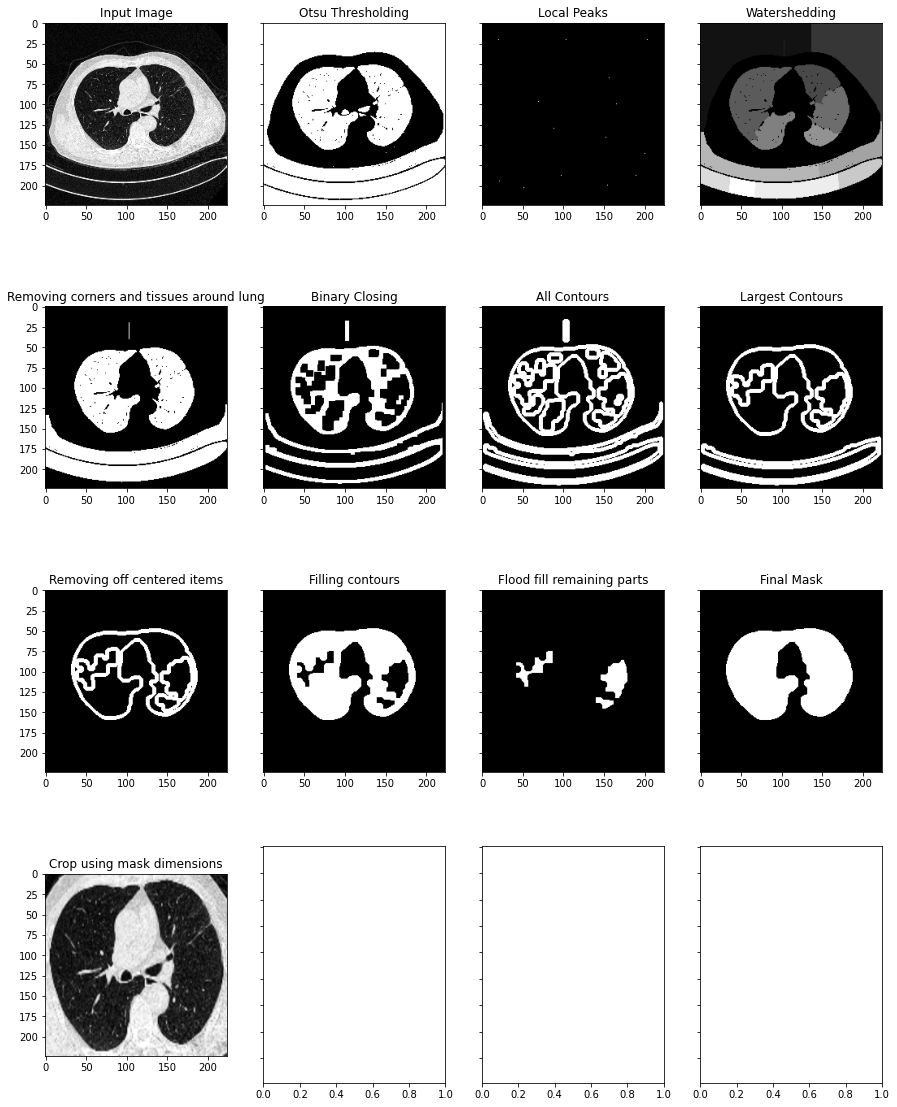

In [6]:
img = cv2.imread("C:/Users/Ajay/OneDrive/Projects/COVID/COVID-DATASET/Non-COVID/nCT1.jpg")
img = cv2.resize(img,(224,224))
img = img.reshape(224,224,3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.uint8)

output = lung_segment(img)
lungarea = output[-1]
img = img.astype(np.float32)
#lungs = cv2.bitwise_and(img,lungarea)
lungs_cropped = crop(img,lungarea)

f, ((ax0, ax1,ax2,ax3,),(ax4,ax5,ax6,ax7,),(ax8,ax9,ax10,ax11),(ax12,ax13,ax14,ax15),) = plt.subplots(4, 4, sharey=True)
f.set_size_inches((15, 20))
ax0.imshow(img,cmap = 'gray')
ax0.set_title("Input Image")
ax1.imshow(output[0],cmap = 'gray')
ax1.set_title("Otsu Thresholding")
ax2.imshow(output[1],cmap = 'gray')
ax2.set_title("Local Peaks")
ax3.imshow(output[2], cmap = 'gray')
ax3.set_title("Watershedding")
ax4.imshow(output[3], cmap = 'gray')
ax4.set_title("Removing corners and tissues around lung")
ax5.imshow(output[4], cmap = 'gray')
ax5.set_title("Binary Closing")
ax6.imshow(output[5], cmap = 'gray')
ax6.set_title("All Contours")
ax7.imshow(output[6], cmap = 'gray')
ax7.set_title("Largest Contours")
ax8.imshow(output[7], cmap = 'gray')
ax8.set_title("Removing off centered items")
ax9.imshow(output[8], cmap = 'gray')
ax9.set_title("Filling contours")
ax10.imshow(output[9], cmap = 'gray')
ax10.set_title("Flood fill remaining parts")
ax11.imshow(output[10], cmap = 'gray')
ax11.set_title("Final Mask")
ax12.imshow(lungs_cropped, cmap = 'gray')
ax12.set_title("Crop using mask dimensions")
f.show()

# Saving cropped image into new dataset

In [13]:
p_count = 1
n_count = 1
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    
    #convert RGB to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.uint8)
    
    #apply gaussian blur
    img = cv2.GaussianBlur(img,(5,5),0)
    img2 = img.astype(np.uint8)
    
    lungarea = lung_segment(img)

    img = img.astype(np.uint8)
    
    name = ""
    if label == 0:
        name+="C:/Users/Ajay/OneDrive/Projects/COVID/IMAGES_NoHist2000/NON-COVID/NON-COVID_"+str(n_count)+".png"
        n_count+=1
    else:
        name+="C:/Users/Ajay/OneDrive/Projects/COVID/IMAGES_NoHist2000/COVID/COVID_"+str(p_count)+".png"
        p_count+=1
    
    try:
        lungs_cropped = crop(img,lungarea)
        print(i,cv2.imwrite(name,lungs_cropped))
        
    except:print(i,name)

True
True
True
